# HMM-Based Spoken Digit Recognition

This notebook implements a Hidden Markov Model (HMM) based system for recognizing spoken digits using the Free Spoken Digit Dataset (FSDD). The system:

1. **Trains HMM models** for digits 0-9 using MFCC features
2. **Processes test audio** from counting.mp3
3. **Recognizes spoken digits** using trained models
4. **Evaluates performance** with accuracy metrics
5. **Experiments with different HMM parameters**

**Dataset:** Free Spoken Digit Dataset (FSDD) - 3,000 recordings of digits 0-9
**Test Audio:** counting.mp3 (digits spoken sequentially)

In [49]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from hmmlearn import hmm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import os
import glob
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Dataset Exploration

Let's explore the Free Spoken Digit Dataset structure and understand our data.

Total audio files found: 3000
Dataset Statistics:
Total recordings: 3000
Speakers: 6
Recordings per digit: [300, 300, 300, 300, 300, 300, 300, 300, 300, 300]


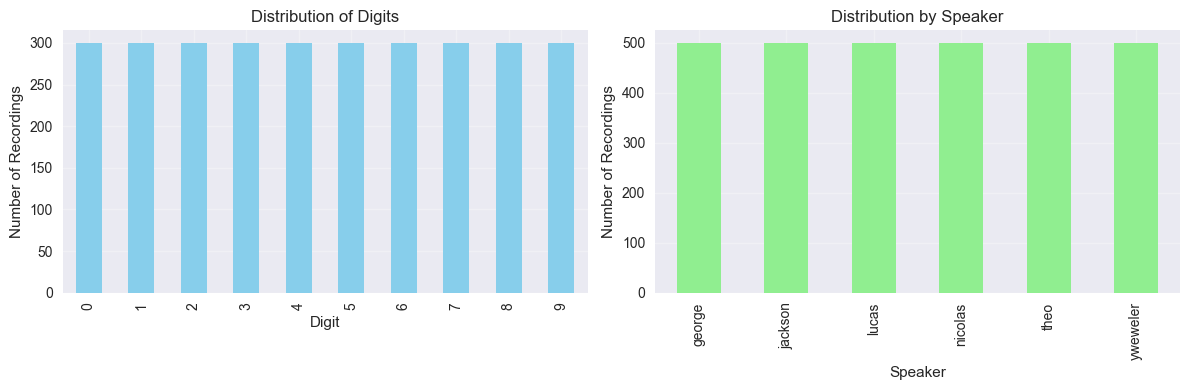

,digit,speaker,recording_id,filepath
0,0,george,0,free-spoken-digit-dataset/recordings/0_george_...
1,0,george,1,free-spoken-digit-dataset/recordings/0_george_...
2,0,george,10,free-spoken-digit-dataset/recordings/0_george_...
3,0,george,11,free-spoken-digit-dataset/recordings/0_george_...
4,0,george,12,free-spoken-digit-dataset/recordings/0_george_...


In [50]:
# Dataset paths
dataset_path = "free-spoken-digit-dataset/recordings"
test_audio_path = "counting.mp3"

# Get all audio files
audio_files = glob.glob(os.path.join(dataset_path, "*.wav"))
audio_files.sort()

print(f"Total audio files found: {len(audio_files)}")

# Parse filenames to extract digit labels and speakers
file_info = []
for file_path in audio_files:
    filename = os.path.basename(file_path)
    parts = filename.split('_')
    if len(parts) >= 3:
        digit = int(parts[0])
        speaker = parts[1]
        recording_id = int(parts[2].split('.')[0])
        file_info.append({
            'digit': digit,
            'speaker': speaker,
            'recording_id': recording_id,
            'filepath': file_path
        })

df_files = pd.DataFrame(file_info)

# Dataset statistics
digit_counts = df_files['digit'].value_counts().sort_index()
speaker_counts = df_files['speaker'].value_counts()

print("Dataset Statistics:")
print(f"Total recordings: {len(df_files)}")
print(f"Speakers: {len(speaker_counts)}")
print(f"Recordings per digit: {digit_counts.tolist()}")

# Visualize digit distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

digit_counts.plot(kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Distribution of Digits')
ax1.set_xlabel('Digit')
ax1.set_ylabel('Number of Recordings')
ax1.grid(True, alpha=0.3)

speaker_counts.plot(kind='bar', ax=ax2, color='lightgreen')
ax2.set_title('Distribution by Speaker')
ax2.set_xlabel('Speaker')
ax2.set_ylabel('Number of Recordings')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

df_files.head()

## 2. Feature Extraction

We'll extract Mel-Frequency Cepstral Coefficients (MFCCs) from audio files, which are commonly used for speech recognition tasks.

Extracting MFCC features from all audio files...
Processed 300/3000 files...
Processed 300/3000 files...
Processed 600/3000 files...
Processed 600/3000 files...
Processed 900/3000 files...
Processed 900/3000 files...
Processed 1200/3000 files...
Processed 1200/3000 files...
Processed 1500/3000 files...
Processed 1500/3000 files...
Processed 1800/3000 files...
Processed 1800/3000 files...
Processed 2100/3000 files...
Processed 2100/3000 files...
Processed 2400/3000 files...
Processed 2400/3000 files...
Processed 2700/3000 files...
Processed 2700/3000 files...
Processed 3000/3000 files...

Feature extraction complete!
Features shape: (3000, 100, 13)
Labels shape: (3000,)
Feature dimensions: 100 time steps × 13 MFCC coefficients
Processed 3000/3000 files...

Feature extraction complete!
Features shape: (3000, 100, 13)
Labels shape: (3000,)
Feature dimensions: 100 time steps × 13 MFCC coefficients


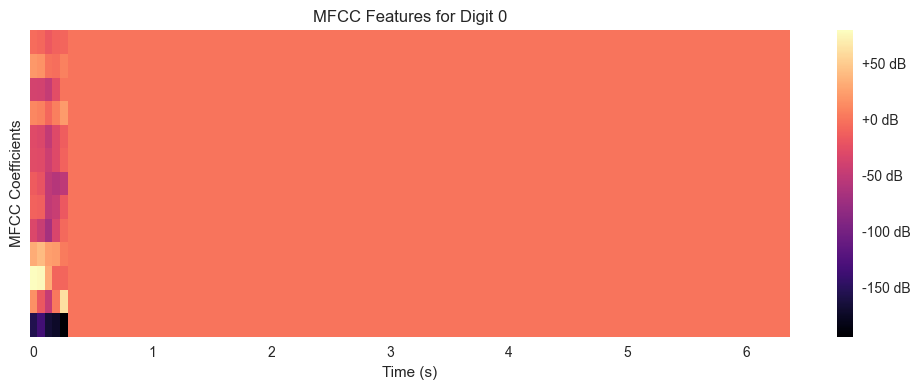

((3000, 100, 13), (3000,))

In [51]:
# MFCC extraction parameters
n_mfcc = 13  # Number of MFCC coefficients
n_fft = 2048  # FFT window size
hop_length = 512  # Hop length for STFT
sr = 8000  # Target sampling rate

def extract_mfcc_features(file_path, max_len=100):
    """Extract MFCC features from audio file"""
    try:
        # Load audio
        y, sr_actual = librosa.load(file_path, sr=sr)

        # Extract MFCCs
        mfccs = librosa.feature.mfcc(y=y, sr=sr_actual, n_mfcc=n_mfcc,
                                   n_fft=n_fft, hop_length=hop_length)

        # Transpose to get time x features
        mfccs = mfccs.T

        # Pad or truncate to fixed length
        if len(mfccs) < max_len:
            # Pad with zeros
            pad_width = max_len - len(mfccs)
            mfccs = np.pad(mfccs, ((0, pad_width), (0, 0)), mode='constant')
        else:
            # Truncate
            mfccs = mfccs[:max_len]

        return mfccs
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Extract features for all files
print("Extracting MFCC features from all audio files...")
features = []
labels = []

for idx, row in df_files.iterrows():
    mfccs = extract_mfcc_features(row['filepath'])
    if mfccs is not None:
        features.append(mfccs)
        labels.append(row['digit'])

    if (idx + 1) % 300 == 0:
        print(f"Processed {idx + 1}/{len(df_files)} files...")

features = np.array(features)
labels = np.array(labels)

print(f"\nFeature extraction complete!")
print(f"Features shape: {features.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Feature dimensions: {features.shape[1]} time steps × {features.shape[2]} MFCC coefficients")

# Visualize sample MFCCs
sample_idx = 0
sample_digit = labels[sample_idx]
sample_features = features[sample_idx]

fig, ax = plt.subplots(figsize=(10, 4))
librosa.display.specshow(sample_features.T, x_axis='time', sr=sr, hop_length=hop_length, ax=ax)
ax.set_title(f'MFCC Features for Digit {sample_digit}')
ax.set_ylabel('MFCC Coefficients')
ax.set_xlabel('Time (s)')
plt.colorbar(ax.collections[0], ax=ax, format='%+2.0f dB')
plt.tight_layout()
plt.show()

features.shape, labels.shape

In [52]:
# --- 3. Prepare variable-length MFCC sequences (no padding) and split into train/test ---
def extract_mfcc_sequence(file_path):
    """Return MFCC sequence (time x n_mfcc) without padding/truncation."""
    try:
        y, sr_actual = librosa.load(file_path, sr=sr)
        mfccs = librosa.feature.mfcc(y=y, sr=sr_actual, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length).T
        # Reject extremely short clips
        if mfccs.shape[0] < 5:
            return None
        return mfccs
    except Exception as e:
        print(f"Error extracting sequence from {file_path}: {e}")
        return None

# Build sequences grouped by digit
from sklearn.model_selection import train_test_split
sequences_by_digit = {d: [] for d in range(10)}
file_paths = df_files['filepath'].tolist()
labels_all = df_files['digit'].tolist()
for fp, lab in zip(file_paths, labels_all):
    seq = extract_mfcc_sequence(fp)
    if seq is not None:
        sequences_by_digit[lab].append(seq)

# Create train/test split per digit to ensure balanced evaluation
train_seqs = []
train_labels = []
test_seqs = []
test_labels = []
for d, seqs in sequences_by_digit.items():
    if len(seqs) == 0:
        continue
    # use an 80/20 split per digit
    tr, te = train_test_split(seqs, test_size=0.2, random_state=42)
    train_seqs.extend(tr)
    train_labels.extend([d] * len(tr))
    test_seqs.extend(te)
    test_labels.extend([d] * len(te))

print(f"Total training sequences: {len(train_seqs)}")
print(f"Total testing sequences: {len(test_seqs)}")

Total training sequences: 2243
Total testing sequences: 565


In [53]:
# --- 4. Train one GaussianHMM per digit ---
from hmmlearn.hmm import GaussianHMM
models = {}
n_states = 4 
cov_type = 'diag'
max_iter = 200
for d in range(10):
    # get training sequences for this digit
    seqs = [s for s, lab in zip(train_seqs, train_labels) if lab == d]
    if len(seqs) == 0:
        continue
    # concatenate and provide lengths
    lengths = [s.shape[0] for s in seqs]
    X = np.concatenate(seqs, axis=0)
    # train model (wrap in try in case of convergence issues)
    model = GaussianHMM(n_components=n_states, covariance_type=cov_type, n_iter=max_iter, random_state=42, verbose=False)
    try:
        model.fit(X, lengths)
        models[d] = model
        print(f"Trained HMM for digit {d} (n_seqs={len(seqs)}, total_frames={X.shape[0]})")
    except Exception as e:
        print(f"Failed to train HMM for digit {d}: {e}")

print("Training complete. Models available:", sorted(models.keys()))
# mark that we have trained HMMs in this kernel session to avoid duplicate retraining
trained_hmms = True
# record which cell trained the models
models_trained_by = 'main'

Trained HMM for digit 0 (n_seqs=240, total_frames=2019)
Trained HMM for digit 1 (n_seqs=218, total_frames=1551)
Trained HMM for digit 1 (n_seqs=218, total_frames=1551)
Trained HMM for digit 2 (n_seqs=210, total_frames=1441)
Trained HMM for digit 2 (n_seqs=210, total_frames=1441)
Trained HMM for digit 3 (n_seqs=207, total_frames=1519)
Trained HMM for digit 3 (n_seqs=207, total_frames=1519)
Trained HMM for digit 4 (n_seqs=230, total_frames=1628)
Trained HMM for digit 4 (n_seqs=230, total_frames=1628)
Trained HMM for digit 5 (n_seqs=237, total_frames=1797)
Trained HMM for digit 5 (n_seqs=237, total_frames=1797)
Trained HMM for digit 6 (n_seqs=198, total_frames=1680)
Trained HMM for digit 6 (n_seqs=198, total_frames=1680)
Trained HMM for digit 7 (n_seqs=235, total_frames=1826)
Trained HMM for digit 7 (n_seqs=235, total_frames=1826)
Trained HMM for digit 8 (n_seqs=229, total_frames=1595)
Trained HMM for digit 8 (n_seqs=229, total_frames=1595)
Trained HMM for digit 9 (n_seqs=239, total_frame

In [54]:
# --- 5. Evaluate on held-out test set ---
y_true = []
y_pred = []
for seq, true_label in zip(test_seqs, test_labels):
    scores = {}
    for d, model in models.items():
        try:
            scores[d] = model.score(seq)
        except Exception:
            scores[d] = -np.inf
    if len(scores) == 0:
        pred = None

Loaded counting.mp3: 133.47s at 8000 Hz
Segment predictions (start_s -> end_s):
4.00s - 5.89s -> predicted: 1 (score=-1793.77)
5.89s - 7.78s -> predicted: 2 (score=-1755.20)
7.78s - 9.67s -> predicted: 7 (score=-1742.10)
9.67s - 11.56s -> predicted: 5 (score=-1770.91)
11.56s - 13.44s -> predicted: 5 (score=-1770.23)
13.44s - 15.33s -> predicted: 5 (score=-1735.07)
15.33s - 17.22s -> predicted: 1 (score=-1766.26)
17.22s - 19.11s -> predicted: 1 (score=-1752.57)
19.11s - 21.00s -> predicted: 1 (score=-1753.67)


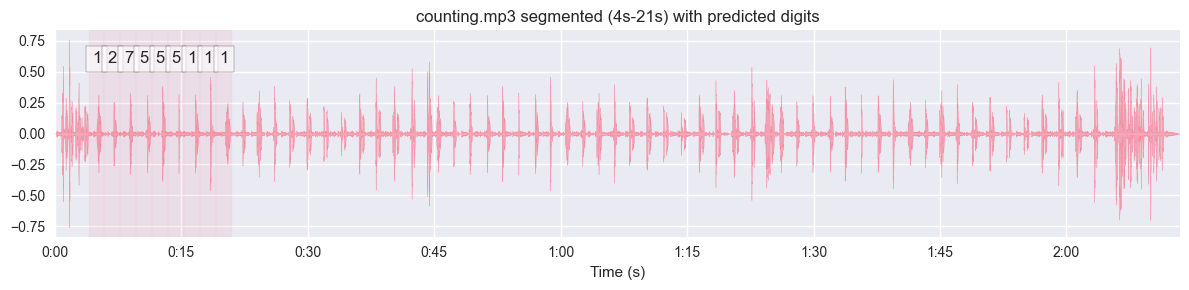

In [56]:
# --- 6. Segment counting.mp3 (4s-21s) into 10 parts and predict each ---
# Settings: start at 4s, end at 21s, split into 10 equal segments
start_s = 4.0
end_s = 21.0
n_segments = 9
segment_duration = (end_s - start_s) / n_segments

# Load the counting audio
y_full, sr_full = librosa.load(test_audio_path, sr=sr)
total_duration = len(y_full) / sr_full
print(f'Loaded {test_audio_path}: {total_duration:.2f}s at {sr_full} Hz')

# Ensure requested slice is within audio duration
if end_s > total_duration:
    raise ValueError(f'Requested end time {end_s}s is beyond audio length {total_duration:.2f}s')

predictions = []
segment_mfccs = []
times = []
for i in range(n_segments):
    seg_start = start_s + i * segment_duration
    seg_end = seg_start + segment_duration
    start_sample = int(seg_start * sr_full)
    end_sample = int(seg_end * sr_full)
    y_seg = y_full[start_sample:end_sample]
    times.append((seg_start, seg_end))

    # extract MFCC sequence (variable length) using same params as training
    mfcc = librosa.feature.mfcc(y=y_seg, sr=sr_full, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length).T
    # If too short, pad with zeros to have at least 5 frames
    if mfcc.shape[0] < 5:
        pad = 5 - mfcc.shape[0]
        mfcc = np.pad(mfcc, ((0, pad), (0, 0)), mode='constant')

    segment_mfccs.append(mfcc)

    # Score with each trained HMM and pick best
    best_digit = None
    best_score = -np.inf
    if len(models) == 0:
        print('No trained HMM models found in `models` dictionary. Train models first.')
    else:
        for d, model in models.items():
            try:
                sc = model.score(mfcc)
            except Exception:
                sc = -np.inf
            if sc > best_score:
                best_score = sc
                best_digit = d
    predictions.append((best_digit, best_score))

# Display predictions
print('Segment predictions (start_s -> end_s):')
for (s, e), (digit, score) in zip(times, predictions):
    print(f'{s:.2f}s - {e:.2f}s -> predicted: {digit} (score={score:.2f})')

# Optional: plot waveform with segment boundaries and predicted labels
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 3))
librosa.display.waveshow(y_full, sr=sr_full, alpha=0.6)
for idx, ((s, e), (digit, _)) in enumerate(zip(times, predictions)):
    plt.axvspan(s, e, color='C0', alpha=0.1)
    plt.text((s+e)/2, 0.8 * np.max(np.abs(y_full)), str(digit), ha='center', va='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.6))
plt.title('counting.mp3 segmented (4s-21s) with predicted digits')
plt.xlim(0, total_duration)
plt.xlabel('Time (s)')
plt.tight_layout()
plt.show()

Training/evaluating: n_states=3, cov_type=diag
  Accuracy (valid preds): 0.8832 (valid_count=565/565)
Training/evaluating: n_states=3, cov_type=full
  Accuracy (valid preds): 0.8832 (valid_count=565/565)
Training/evaluating: n_states=3, cov_type=full
  Accuracy (valid preds): 0.9770 (valid_count=565/565)
Training/evaluating: n_states=4, cov_type=diag
  Accuracy (valid preds): 0.9770 (valid_count=565/565)
Training/evaluating: n_states=4, cov_type=diag
  Accuracy (valid preds): 0.9204 (valid_count=565/565)
Training/evaluating: n_states=4, cov_type=full
  Accuracy (valid preds): 0.9204 (valid_count=565/565)
Training/evaluating: n_states=4, cov_type=full
  Accuracy (valid preds): 0.9894 (valid_count=565/565)
Training/evaluating: n_states=5, cov_type=diag
  Accuracy (valid preds): 0.9894 (valid_count=565/565)
Training/evaluating: n_states=5, cov_type=diag
  Accuracy (valid preds): 0.9434 (valid_count=565/565)
Training/evaluating: n_states=5, cov_type=full
  Accuracy (valid preds): 0.9434 (v

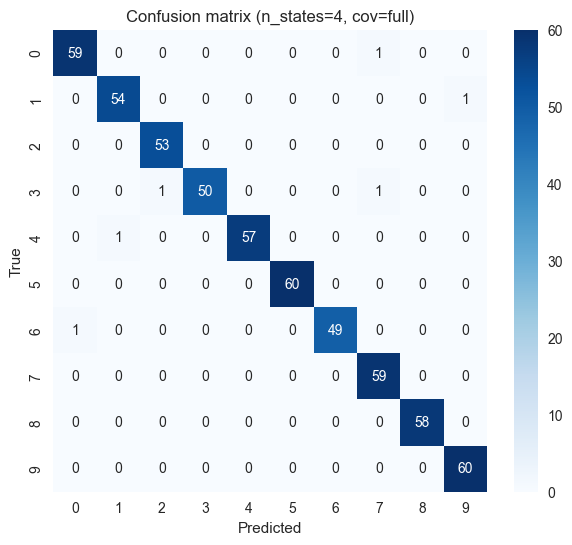

In [60]:
# --- Bonus: Grid-search HMM parameters and report effects on accuracy ---
from hmmlearn.hmm import GaussianHMM
from sklearn.metrics import confusion_matrix
import pandas as pd

# Parameter grid (small to keep run-time reasonable). Modify as needed.
n_states_list = [3, 4, 5]
cov_types = ['diag', 'full']
max_iter_exp = 100

results = []
for n_states in n_states_list:
    for cov in cov_types:
        print(f'Training/evaluating: n_states={n_states}, cov_type={cov}')
        # Train one HMM per digit with these hyperparameters
        models_exp = {}
        for d in range(10):
            seqs = [s for s, lab in zip(train_seqs, train_labels) if lab == d]
            if len(seqs) == 0:
                continue
            lengths = [s.shape[0] for s in seqs]
            X = np.concatenate(seqs, axis=0)
            model = GaussianHMM(n_components=n_states, covariance_type=cov, n_iter=max_iter_exp, random_state=42)
            try:
                model.fit(X, lengths)
                models_exp[d] = model
            except Exception as e:
                print(f'  Failed train digit {d}: {e}')

        # Evaluate on the held-out test set defined earlier (test_seqs/test_labels)
        y_true_exp = []
        y_pred_exp = []
        for seq, true_label in zip(test_seqs, test_labels):
            scores = {}
            for d, model in models_exp.items():
                try:
                    scores[d] = model.score(seq)
                except Exception:
                    scores[d] = -np.inf
            if len(scores) == 0:
                pred = None
            else:
                pred = max(scores, key=scores.get)
            y_true_exp.append(true_label)
            y_pred_exp.append(pred)

        # Compute accuracy excluding None predictions
        valid_idx = [i for i, p in enumerate(y_pred_exp) if p is not None]
        if len(valid_idx) == 0:
            acc = float('nan')
        else:
            acc = accuracy_score([y_true_exp[i] for i in valid_idx], [y_pred_exp[i] for i in valid_idx])
        print(f'  Accuracy (valid preds): {acc:.4f} (valid_count={len(valid_idx)}/{len(y_pred_exp)})')
        results.append({'n_states': n_states, 'cov_type': cov, 'accuracy': acc, 'valid_count': len(valid_idx)})

# Summarize results
df_results = pd.DataFrame(results).sort_values(['accuracy'], ascending=False).reset_index(drop=True)
print('Summary of experiments:')
print(df_results)

# Show confusion matrix for best setting (first valid best)
best_row = df_results.dropna(subset=['accuracy']).head(1)
if not best_row.empty:
    best_ns = int(best_row.loc[0, 'n_states'])
    best_cov = best_row.loc[0, 'cov_type']
    print(f'Best params -> n_states={best_ns}, cov_type={best_cov}')
    # (retrain to get the models for best params)
    best_models = {}
    for d in range(10):
        seqs = [s for s, lab in zip(train_seqs, train_labels) if lab == d]
        if len(seqs) == 0:
            continue
        lengths = [s.shape[0] for s in seqs]
        X = np.concatenate(seqs, axis=0)
        m = GaussianHMM(n_components=best_ns, covariance_type=best_cov, n_iter=max_iter_exp, random_state=42)
        try:
            m.fit(X, lengths)
            best_models[d] = m
        except Exception as e:
            print(f'  Failed retrain digit {d} for best params: {e}')

    y_true_best = []
    y_pred_best = []
    for seq, true_label in zip(test_seqs, test_labels):
        scores = {}
        for d, model in best_models.items():
            try:
                scores[d] = model.score(seq)
            except Exception:
                scores[d] = -np.inf
        if len(scores) == 0:
            pred = None
        else:
            pred = max(scores, key=scores.get)
        y_true_best.append(true_label)
        y_pred_best.append(pred)

    # Filter valid predictions
    valid_idx = [i for i, p in enumerate(y_pred_best) if p is not None]
    if len(valid_idx) > 0:
        cm = confusion_matrix([y_true_best[i] for i in valid_idx], [y_pred_best[i] for i in valid_idx], labels=list(range(10)))
        plt.figure(figsize=(7, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion matrix (n_states={best_ns}, cov={best_cov})')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
    else:
        print('No valid predictions for best parameters - cannot compute confusion matrix')
else:
    print('No successful experiment runs found (all NaN accuracies)')